In [1]:
import jax.numpy as jnp
import b3d
import os
import trimesh
import matplotlib.pyplot as plt
import jax
from b3d.renderer.renderer_original import RendererOriginal

In [2]:
mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
mesh.vertices = mesh.vertices - mesh.vertices.mean(axis=0)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

/opt/conda/envs/b3d/lib/python3.10/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


In [3]:
print("Number of vertices: ", object_library.vertices.shape[0])

Number of vertices:  10689


In [4]:
import b3d.colors

In [5]:
# def beta_logpdf(obs_image, rendered_image, multiplier, outlier_prob):
#     distances = jnp.abs(obs_image - rendered_image)
#     probabilities = jax.scipy.stats.beta.logpdf(
#         obs_image, 1 + rendered_image * multiplier, 1 + (1.0 - rendered_image) *  multiplier
#     )
#     probabilities_adjusted = jnp.logaddexp(
#         probabilities + jnp.log(1.0 - outlier_prob),
#         jnp.log(outlier_prob)
#     )
#     return probabilities_adjusted.sum()

# def beta_sample(key, rendered_image, multiplier, outlier_prob):
#     return jax.random.beta(
#         key, 1 + rendered_image * multiplier, 1 + (1.0 - rendered_image) *  multiplier, shape=rendered_image.shape
#     )


def gaussian_logpdf(obs_image, rendered_image,b, multiplier, a, outlier_prob):
    probabilities = jax.scipy.stats.norm.logpdf(
        obs_image, rendered_image, multiplier
    )
    probabilities_adjusted = jnp.logaddexp(
        probabilities + jnp.log(1.0 - outlier_prob),
        jnp.log(outlier_prob)
    )
    return probabilities_adjusted.sum()

def gaussian_sample(key, rendered_image, b,multiplier, a, outlier_prob):
    return jax.random.normal(
        key, shape=rendered_image.shape
    ) * multiplier + rendered_image


def new_logpdf(observed_rgb, rendered_rgb, rendered_depth, multiplier, color_tolerance, outlier_prob):
    observed_lab = b3d.colors.rgb_to_lab(observed_rgb)
    rendered_lab = b3d.colors.rgb_to_lab(rendered_rgb)
    error = (
        jnp.linalg.norm(observed_lab[...,1:3] - rendered_lab[...,1:3], axis=-1) + 
        jnp.abs(observed_lab[...,0] - rendered_lab[...,0])
    )

    valid_data_mask = (rendered_rgb.sum(-1) != 0.0)

    color_inliers = (error < color_tolerance) * valid_data_mask
    inliers = color_inliers
    outliers = jnp.logical_not(inliers) * valid_data_mask
    undecided = jnp.logical_not(inliers) * jnp.logical_not(outliers)

    corrected_depth = rendered_depth + (rendered_depth == 0.0) * 0.1
    areas = (corrected_depth / fx) * (corrected_depth / fy)

    inlier_score = 4.0
    return jnp.log(
        # This is leaving out a 1/A (which does depend upon the scene)
        inlier_score * jnp.sum(inliers * areas) +
        1.0 * jnp.sum(undecided * areas)  +
        outlier_prob * jnp.sum(outliers * areas)
    ) * multiplier

def new_sample(rendered_rgb, rendered_depth, multiplier, color_tolerance, outlier_prob):
    corrected_depth = rendered_depth + (rendered_depth == 0.0) * 1.0
    areas = (corrected_depth / fx) * (corrected_depth / fy)
    sampled_indices = jax.random.categorical(areas)


pose_from_x = lambda x: b3d.Pose.from_position_and_target(
    jnp.array([0.0, -0.3, 0.1]),
    jnp.zeros(3)
).inv() @ b3d.Pose.from_translation(jnp.array([x, 0.0, 0.0]))
N = 500
scanned_x_value = jnp.linspace(-0.01, 0.01, N)
poses = jax.vmap(pose_from_x)(scanned_x_value)
transformed_vertices = jax.vmap(lambda i: poses[i].apply(object_library.vertices))(jnp.arange(len(poses)))

In [6]:
h,w,fx,fy,cx,cy = 50, 50, 100.0, 100.0, 25.0, 25.0
renderers = [
    RendererOriginal(scale * h, scale *w, scale * fx, scale * fy, scale * cx, scale * cy, 0.01, 10.0)
    for scale in [1, 3, 5, 7, 9]
]

In [7]:
def render_rgbd_many(renderer, vertices, faces, attributes):
    return renderer.render_many(
        transformed_vertices,
        object_library.faces,
        jnp.concatenate([attributes, transformed_vertices[...,-1:]],axis=-1)
    )

(150, 150, 4)


(-0.5, 149.5, 149.5, -0.5)

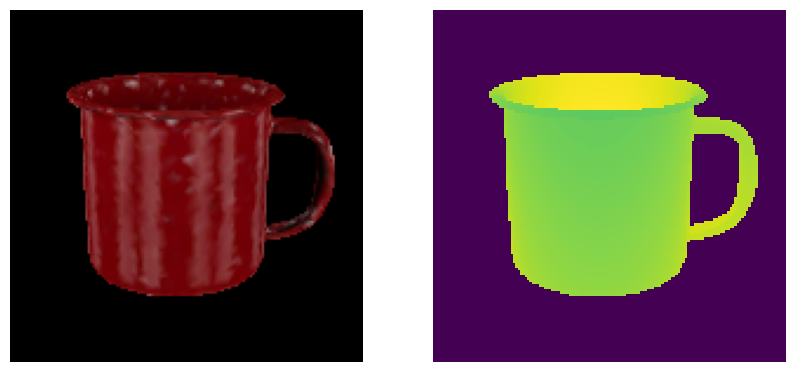

In [8]:
all_images = [
        render_rgbd_many(r,
        transformed_vertices,
        object_library.faces,
        jnp.tile(object_library.attributes, (N,1,1)),
    )
    for r in renderers
]
images = all_images[1]
gt_image = images[N//2]
print(gt_image.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Display the first image in the first subplot
ax1.imshow(gt_image[...,:3])
ax1.axis('off')  # Hide the axis

# Display the second image in the second subplot
ax2.matshow(gt_image[...,3])
ax2.axis('off')  # Hide the axis


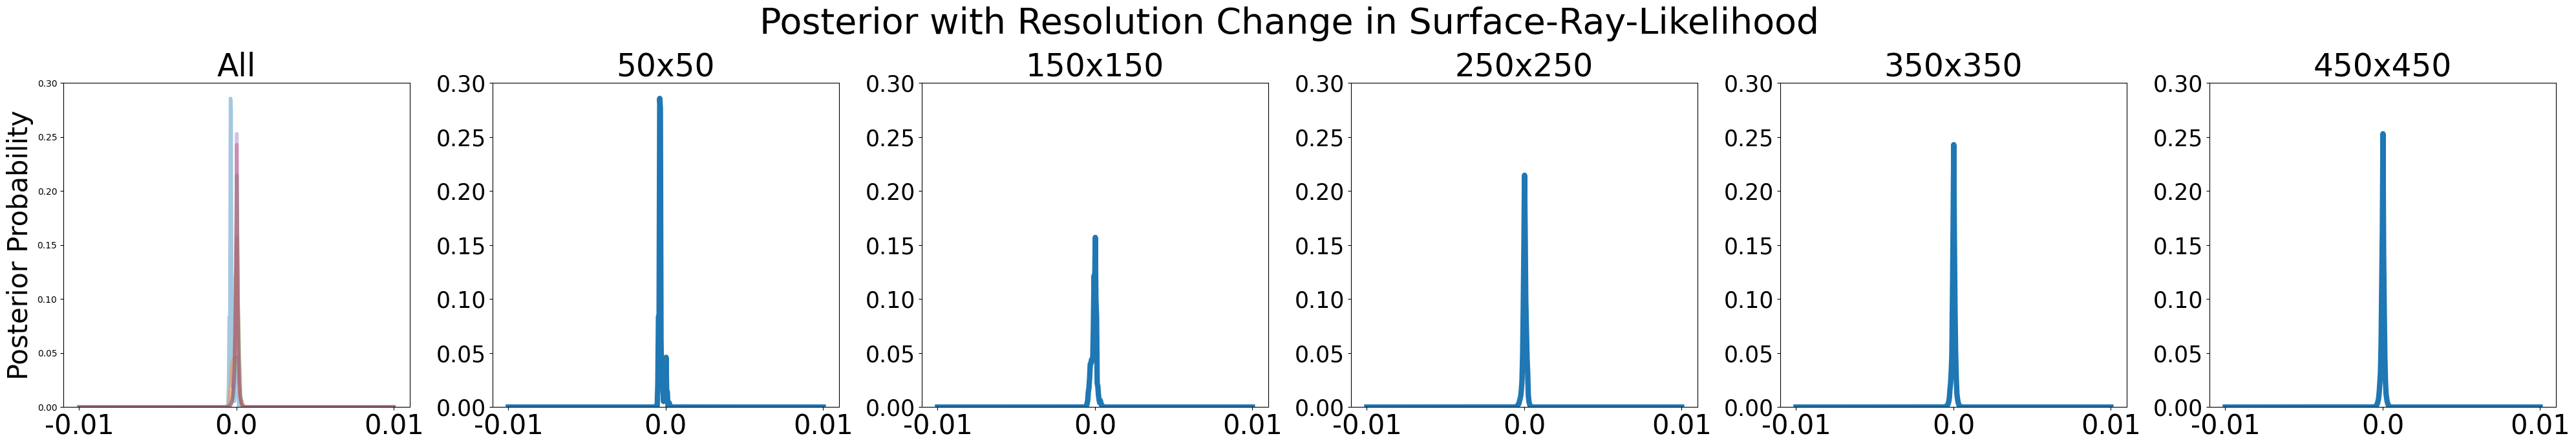

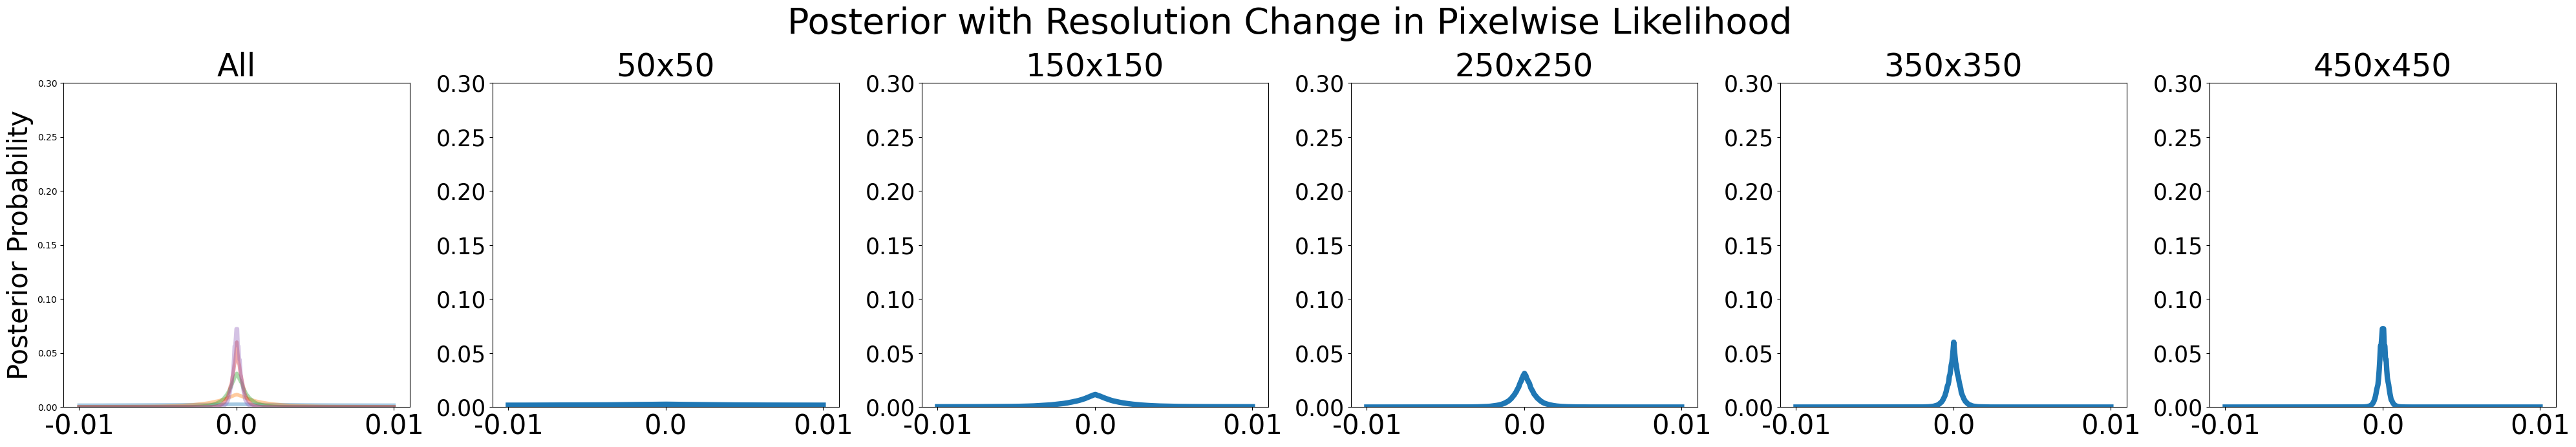

In [9]:
figs = []
settings = [
    (1000.0, 60.0, 0.05, new_logpdf, "Posterior with Resolution Change in Surface-Ray-Likelihood"),
    (6.0, 50.0, 0.1, gaussian_logpdf, "Posterior with Resolution Change in Pixelwise Likelihood")
]
for setting in settings:
    fig, axes = plt.subplots(1, len(renderers) + 1, figsize=(40, 7))
    title = None
    for IDX in range(len(renderers)):
        
        r = renderers[IDX]
        images = all_images[IDX]
        gt_image = images[N // 2][...,:3]

        (multiplier, variance, outlier_prob, logpdf_func, title) = setting
        logpdfs = jax.vmap(logpdf_func, in_axes=(None, 0, 0, None, None, None))(gt_image,
                                                                               images[...,:3], images[...,3], multiplier, variance, outlier_prob)
        
        axes[0].plot(scanned_x_value, b3d.normalize_log_scores(logpdfs), alpha=0.4, label=f"{r.height}x{r.width}", linewidth=4)
        axes[IDX+1].plot(scanned_x_value, b3d.normalize_log_scores(logpdfs), alpha=1.0, label=f"{r.height}x{r.width}", linewidth=6)
        axes[IDX+1].set_ylim(0.0, 0.3)
        axes[IDX+1].set_xticks([scanned_x_value.min(), 0.0, scanned_x_value.max()])
        axes[IDX+1].set_xticklabels([scanned_x_value.min(), 0.0, scanned_x_value.max()], fontsize=30)
        axes[IDX+1].set_title(f"{r.height}x{r.width}", fontsize=35)
        axes[IDX+1].tick_params(axis='y', labelsize=25)
        
    axes[0].set_ylim(0.0, 0.3)
    axes[0].set_xticks([scanned_x_value.min(), 0.0, scanned_x_value.max()])
    axes[0].set_xticklabels([scanned_x_value.min(), 0.0, scanned_x_value.max()], fontsize=30)
    axes[0].set_title(f"All", fontsize=35)
    
    # axes[0]([scanned_x_value.min(), 0.0, scanned_x_value.max()])
    axes[0].set_ylabel("Posterior Probability", fontsize=30)
    # plt.xlabel("X coordinate", fontsize=22)
    plt.suptitle(title, fontsize=40) 
    plt.tight_layout()
    figs.append(fig)


(250, 250, 4)
10000


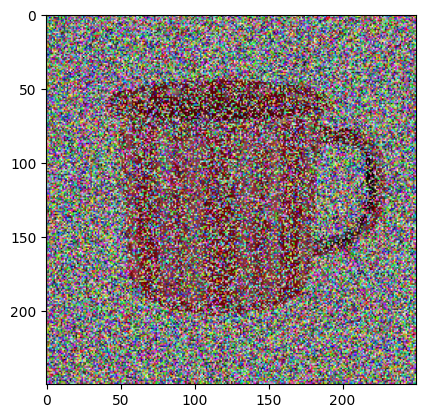

In [11]:


gt_image = all_images[2][N//2]
print(gt_image.shape)
(multiplier, variances, outlier_prob, logpdf_func, title) = settings[0]


multiplier = 10000
print(multiplier)
rendered_rgb = gt_image[...,:3]
rendered_depth = gt_image[...,3]

corrected_depth = rendered_depth + (rendered_depth == 0.0) * 0.01
areas = (corrected_depth / fx) * (corrected_depth / fy)


indices = jax.random.categorical(jax.random.PRNGKey(1), jnp.log(areas / areas.sum()).reshape(-1), shape=(jnp.int32(multiplier),))

ii,jj = jax.vmap(jnp.unravel_index, in_axes=(0,None))(indices, areas.shape)
img = jnp.zeros_like(rendered_rgb)


img = jax.random.uniform(jax.random.PRNGKey(10), shape=rendered_rgb.shape)
# img = img.at[ii,jj,:].set(0.0)

img = img.at[ii,jj,:].set(rendered_rgb[ii,jj])
# img = img.at[ii,jj,:].set(1.0)
plt.imshow(img)